In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz
import seaborn as sns
from sklearn.metrics import adjusted_rand_score

In [21]:
################################################## HELPER FUNCTIONS #################################################################################### 
def z_scoring(x): 
    return (x - x.mean()) / x.std()

def range_normalization(x):
    return (x - x.mean()) / (x.max() - x.min())

def center_(x, cluster):
    return [np.mean(x[cluster, j]) for j in range(x.shape[1])]

# Used to group dataPoints in clusters
def distNorm(x ,remains, ranges, p):
    z = x[remains, :]
    az = np.tile(p, (len(remains), 1))
    rz = np.tile(ranges, (len(remains), 1))
    dz = (z - az) / rz
    return np.sum(dz * dz, axis=1)

# To See if it belongs to Cluster X?
def separCluster(x, remains, ranges, a, b):
    dista = distNorm(x, remains, ranges, a)
    distb = distNorm(x, remains, ranges, b)
    return [remains[i] for i in np.where(dista < distb)[0]]

def anomalousPattern(x, remains, ranges, centroid, me):
    while True:
        cluster = separCluster(x, remains, ranges, centroid, me)
        if not cluster:
            break
        newcenter = center_(x, cluster)
        if np.allclose(centroid, newcenter):
            break
        centroid = newcenter
    return cluster, centroid

def dist(x, remains, ranges, p):
    return np.sum(((x[remains] - p) / ranges) ** 2, axis=1)

# Optimized Vectorized implementation
# Validation / Criterion
def xie_beni_index(U, centers, X):
    um = U ** 2
    dist_sq = np.sum((X[np.newaxis, :, :] - centers[:, np.newaxis, :]) ** 2, axis=2)
    compactness = np.sum(um * dist_sq)

    center_dist_sq = np.sum((centers[:, np.newaxis, :] - centers[np.newaxis, :, :]) ** 2, axis=2)
    np.fill_diagonal(center_dist_sq, np.inf)
    min_center_dist_sq = np.min(center_dist_sq)

    if min_center_dist_sq == 0:
        return np.inf
    return compactness / (X.shape[0] * min_center_dist_sq)

def plot_clustering(x, labels, centers, title, score):
    plt.figure(figsize=(8, 6))
    for j in np.unique(labels):
        plt.scatter(x[labels == j, 0], x[labels == j, 1], label=f'Cluster {j+1}')
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, marker='X', label='Centers')
    plt.title(f"{title} (Score={score:.4f})")
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
################################################## DATA PREPARATION #################################################################################### 

# a ) Normalize by range and z-score
# MERGED dataSet
df_r = pd.read_csv("./data/winequality-red.csv", sep=';')
df_w = pd.read_csv("./data/winequality-white.csv", sep=';')
data = pd.concat([df_r, df_w], ignore_index=True)

# Extract features and target
x_values = data.drop(columns=['quality']).values  # features (excluding 'quality')
y_values = data['quality'].values  # target (quality)

# Normalize data by range
means = x_values.mean(axis=0)
Rmax = x_values.max(axis=0)
Rmin = x_values.min(axis=0)

x_norm = (x_values - means) / (Rmax - Rmin)


# Apply SVD for dimensionality reduction (used later in PCA visualization)
u, s, vh = np.linalg.svd(x_norm, full_matrices=False)

# Use the first two singular vectors (U) for 2D projection
u1 = u[:, 0]
u2 = u[:, 1]

# Covariance matrix of the normalized dataset
covmatrix = np.cov(x_norm.T)

# Eigenvalues and eigenvectors of the covariance matrix
e, v = np.linalg.eig(covmatrix)

# Order eigenvalues and eigenvectors in descending order
order = np.argsort(e)[::-1]  # Sort eigenvalues in descending order
e = e[order]
v = v[:, order]

# Print eigenvectors and eigenvalues
print("Eigenvectors:\n", v)
print("\nEigenvalues:\n", e)

# Generate PCA component space (PCA scores)
pc = np.dot(x_norm, v)

# Set data to a Pandas DataFrame for easier plotting
names = ["PC_" + str(x + 1) for x in range(pc.shape[1])]
names.append('target')
data_pca = pd.DataFrame(data=np.c_[pc, y_values], columns=names)
data_pca['target'] = data_pca['target'].astype(int)


#### merge after #####
features = data.drop(columns=['quality'])  # Remove 'quality' column for features
true_labels = data['quality'].values

data_excluding_last_column = data.iloc[:, :-1]

# Then convert the result to a NumPy array and change the dtype
x = data_excluding_last_column.values.astype(np.float32)

normalization = 0
threshold = 25

#number of data points
nn = x.shape[0]
#number of features
mm = x.shape[1]

# grand means
me = []
# maximum value
mmax = []
# minimum value
mmin = []
# ranges
ranges = []
# "anomalous cluster" ancl is the data structure to keep everything together
ancl = []


for j in range(mm): # for each feature
    z = x[:, j]     # data column vector j-th feature
    me.append(np.mean(z))
    mmax.append(np.max(z))
    mmin.append(np.min(z))
    if normalization:
        ranges.append(1)
    else:
        ranges.append(mmax[j] - mmin[j])
    if ranges[j] == 0:
        print("Variable num {} is contant!".format(j))
        ranges[j] = 1
    
sy = np.divide((x - me), ranges)
sY = np.array(sy)
d = np.sum(sY * sY)   # total data scatter of normalized data


# x, me range, d
remains = list(range(nn))  # current index set of residual data after some anomalous clusters are extracted
numberC = 0; # counter of anomalous clusters 
while(len(remains) != 0):
    distance = dist(x, remains, ranges, me) # finding normalised distance vector from remains data points to reference 'me'
    ind = np.argmax(distance)
    index = remains[ind]
    centroid = x[index, :]   # initial anomalous center reference point: the one with higher distance
    numberC = numberC + 1
    
    (cluster, centroid) = anomalousPattern(x, remains, ranges, centroid, me) # finding AP cluster
    
    censtand = np.divide((np.asarray(centroid) - me), np.asarray(ranges)) # standardised centroid with parameters of the data   
    dD = np.sum(np.divide(censtand * censtand.T * len(cluster) * 100, d)) # cluster contribution (per cent) - (lecture on K-means and iK-means)

    remains = np.setdiff1d(remains, cluster) 
    # update the data structure that keeps everything together
    ancl.append((cluster, censtand, dD))

ancl = np.array(ancl, dtype=object)

##aK = numberC
b = 3
ll = [] # list of clusters

for ik in range(numberC):
    ll.append(len(ancl[ik, 0]))
    
rl = [i for i in ll if i >= threshold] # list of clusters with at least threshold elements
cent = []
if(len(rl) == 0):
    print('Too great a threhsold!!!')
else:
    num_cents = 0
    for ik in range(numberC):
        cluster = ancl[ik,0]
        if(len(cluster) >= threshold):
            cent.append(ancl[ik, 1])
            num_cents += 1
                
cent = np.asarray(cent)

#print("\nInitial centroids selected for each cluster:")
#for idx, centroid in enumerate(cent):
 #   print(f"Cluster {idx + 1} centroid: {centroid}")

#init_partition = np.zeros((x.shape[0], len(cent)))

#for index, d in enumerate(x):
 #   dists = [np.linalg.norm(d - c) for c in cent]
  #  dists = np.fmax(dists, 1e-6)
   # inv_dists = 1.0 / dists
    #memberships = inv_dists / np.sum(inv_dists)
    #init_partition[index] = memberships

    #assign = dists.index(np.min(dists))
    #init_partition[index, assign] = 1

#print("Initial cluster assignments (partition matrix): \n", init_partition)

Eigenvectors:
 [[ 4.25846104e-03  3.21162442e-01 -5.67704190e-01 -2.34498702e-01
  -2.07560551e-01 -3.77026610e-01  1.26039601e-01  5.16031654e-01
   8.43501354e-02  3.19609260e-02 -2.09803050e-01]
 [ 1.55279367e-01  4.58232985e-01  1.14164269e-01  4.05096224e-01
  -6.35269943e-01 -7.92117225e-02  1.65358372e-01 -3.13879396e-01
  -1.95421828e-01 -1.09295302e-01 -5.41590227e-02]
 [-9.93159752e-02 -1.20812609e-01 -3.68255319e-01 -4.90768311e-01
  -3.13541845e-03 -1.96204150e-01  1.61782515e-01 -6.98819595e-01
  -1.87347788e-01 -1.04627534e-01  8.45345682e-04]
 [-2.28085790e-01 -8.36233700e-02  9.84661798e-03  2.86622955e-02
  -2.06758610e-01 -1.92893932e-01 -8.08278174e-01 -1.34814144e-01
   5.28361796e-02  6.44572651e-02 -4.26231708e-01]
 [-1.29155698e-02  2.02009203e-01 -5.40675011e-02 -6.15263780e-02
  -7.99255272e-02  2.38447128e-01  1.00963565e-01 -2.76208082e-01
   8.35721872e-01  3.17145610e-01 -5.97881719e-02]
 [-1.57273412e-01 -1.82287031e-01  8.33363742e-02 -7.89342519e-02
  -2

[[ 9.4198518e-02  1.3310556e-01 -3.2827385e-02 -4.4308044e-02
   5.2440695e-02 -5.4242682e-02 -1.6731653e-01  4.0329382e-02
   7.3969632e-02  7.2347149e-02 -8.2983496e-03]
 [-4.3866143e-02 -3.6948502e-02  7.1730781e-03 -2.6291640e-02
  -3.3082422e-02 -1.4070670e-04 -4.3723816e-03 -7.0613191e-02
  -1.7196631e-02 -2.8217811e-02  2.2910146e-01]
 [-2.1363527e-02 -3.9539516e-02  2.3180749e-02  7.2441913e-02
  -2.2394194e-03  4.8857935e-02  1.2780985e-01  4.0055893e-02
  -5.5601235e-02 -2.1675883e-02 -1.6329172e-01]]


/tmp/ipykernel_13114/2873366676.py:31: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='PC_1', y='PC_2', data=data_pca, hue=fuzzy_membership, palette='Set1',


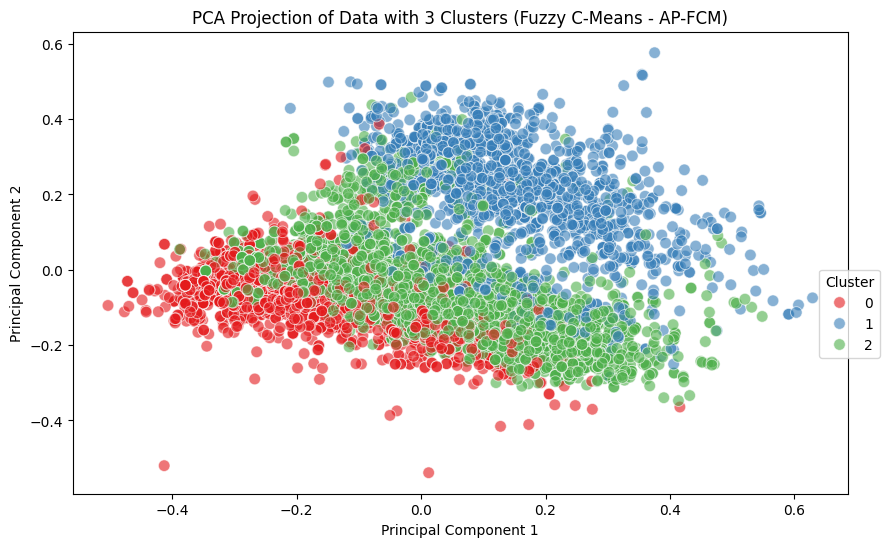

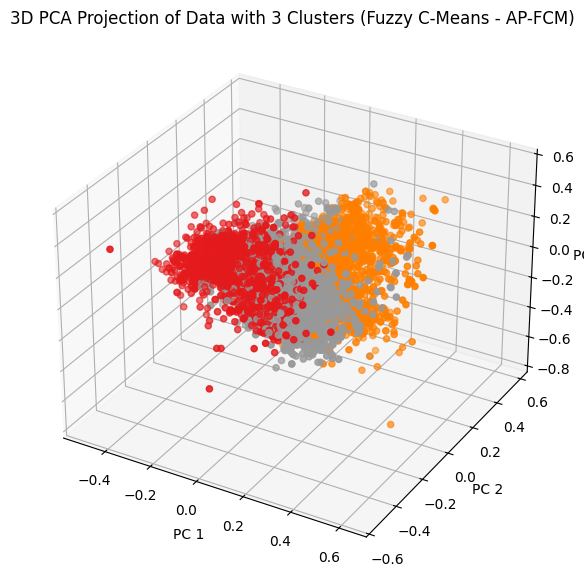

In [35]:
# b) 
c = 3
current_centroids = cent[:c]
print(current_centroids)

# Build init partition for this c
init_partition = np.zeros((x.shape[0], c))
for index, d in enumerate(x):
    dists = [np.linalg.norm(d - c_) for c_ in current_centroids]
    dists = np.fmax(dists, 1e-6)
    inv_dists = 1.0 / dists
    memberships = inv_dists / np.sum(inv_dists)
    init_partition[index] = memberships
    

centers, fm, im, d, jm, i, fpc = fuzz.cluster.cmeans(
    x.T, c, 2.0, 1e-5, 100, init=init_partition.T)


fuzzy_membership = np.argmax(fm, axis=0)  

# Step 4: PCA - Apply PCA to the data
pca = np.dot(x_norm, v)
names = ["PC_" + str(x + 1) for x in range(pc.shape[1])]
names.append('target')
data_pca = pd.DataFrame(data=np.c_[pc, y_values], columns=names)
data_pca['target'] = data_pca['target'].astype(int)

# Step 5: 2D PCA Visualization for fuzzy partitions
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC_1', y='PC_2', data=data_pca, hue=fuzzy_membership, palette='Set1', 
                style=fuzzy_membership, markers='o', s=70, alpha=0.6)
plt.title(f'PCA Projection of Data with {c} Clusters (Fuzzy C-Means - AP-FCM)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 0.5))
plt.show()

# Step 6: 3D PCA Visualization for fuzzy partitions
# Check if fuzzy_membership has three distinct clusters before plotting
if len(np.unique(fuzzy_membership)) == 3:
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_pca['PC_1'], data_pca['PC_2'], data_pca['PC_3'], c=fuzzy_membership, cmap='Set1')
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    ax.set_title(f'3D PCA Projection of Data with {c} Clusters (Fuzzy C-Means - AP-FCM)')
    plt.show()
else:
    print("Warning: Fuzzy membership did not contain 3 distinct clusters.")
